## Portfolio Optimization

The objective of this project is to develop an optimization model that allocates investments across a portfolio that maximizes return and minimizes risk.

This return-risk tradeoff is done using Mean-Variance Optimization (MVO).
MVO focuses on creating a portfolio that maximizes return (Mean) when risk is given, and minimizes risk (Variance or Standard Deviation) when return is given.

We later plot a curve representing a set of optimal portfolios, offering highest expected return for a given level of risk.

We then use Sharpe Ratio to calculates the return of an investment compared to its risk.
The formula is as follows:

$$ Sharpe Ratio = \frac{{R_p} - {R_f}}{{\sigma_p}} $$

where

Rp - average return of the portfolio or investment

Rf - risk free rate of return (return of an investment over a time period with zero risk)

sigma - standard deviation of the portfolio or investment

## 1. Data Collection

In [1]:
#quandl - a library that has access to a vast amount of financial and economical data
!pip3 install quandl

In [2]:
#importing the necessary libraries
import quandl as ql
import pandas as pd

In [3]:
#setting the API configuration key
#create a NASDAQ account to get the API key
ql.ApiConfig.api_key = 'RW8B74o8_zaSoaZTgziM'

In [4]:
#list of tickers
#tickers refer to how a particular stock is addressed
tickers = ['WIKI/MSFT','WIKI/AAPL','WIKI/NVDA','WIKI/GOOGL','WIKI/AMZN']
data = pd.DataFrame()

In [5]:
#fetching data from Quandl
for ticker in tickers:
    df = ql.get(ticker, start_date = '2018-01-01', end_date = '2024-01-01')
    data[ticker.split('/')[1]] = df['Adj. Close']

In [6]:
#first 5 rows of data
data.head()

,MSFT,AAPL,NVDA,GOOGL,AMZN
Date,,,,,
2018-01-02,85.95,172.26,199.35,1073.21,1189.01
2018-01-03,86.35,172.23,212.47,1091.52,1204.20
2018-01-04,87.11,173.03,213.59,1095.76,1209.59
2018-01-05,88.19,175.00,215.40,1110.29,1229.14
2018-01-08,88.28,174.35,222.00,1114.21,1246.87


## 2. Data preprocessing 

In [7]:
data.isna().sum()

MSFT     0
AAPL     0
NVDA     0
GOOGL    0
AMZN     0
dtype: int64

In [8]:
#to calculate returns, we find the pct change in the stock value
returns = data.pct_change().dropna()
print(returns.head())

                MSFT      AAPL      NVDA     GOOGL      AMZN
Date                                                        
2018-01-03  0.004654 -0.000174  0.065814  0.017061  0.012775
2018-01-04  0.008801  0.004645  0.005271  0.003884  0.004476
2018-01-05  0.012398  0.011385  0.008474  0.013260  0.016163
2018-01-08  0.001021 -0.003714  0.030641  0.003531  0.014425
2018-01-09 -0.000680 -0.000115 -0.000270 -0.001274  0.004676


## 3. Expected Returns and Covariance Matrix

Expected returns is the mean of probability distribution of possible returns of an asset.
In simple words, it is the average return an investor might expect over a given period.

For a series of historical returns, Ri

$$ E(R) = (1/n)*\sum_{i=1}^n {R_i} $$

where

n - number of periods

Annually,

$$ E({R_a}) = E({R_d}) * 252 $$

(assuming there are 252 trading days per year)
and a - annual, and d - daily

In [9]:
expected_returns = returns.mean() * 252

In [10]:
expected_returns

MSFT     0.223812
AAPL    -0.064951
NVDA     0.637729
GOOGL   -0.229191
AMZN     1.045849
dtype: float64

The Covariance matrix captures the relation between pairs of assets in a portfolio.

It is used to understand the risk and diversification benefits of owning different assets together.

Also for assessing overall portfolio risk and optimizing the portfolio to achieve best return-risk tradeoff (Mean Variance optimization).

For any two assets **X** and **Y**:

$$ Cov(X,Y) = \frac{1}{n-1}*\sum_{i=1}^n ({X_i} - \bar{X}) * ({Y_i} - \bar{Y}) $$

Annually,

$$ \sum_{annual} = \sum_{daily} * 252 $$

In [11]:
cov_matrix = returns.cov() * 252

In [12]:
print(f'Expected Returns: \n {expected_returns}')
print(f'Covariance Matrix: \n {cov_matrix}')

Expected Returns: 
 MSFT     0.223812
AAPL    -0.064951
NVDA     0.637729
GOOGL   -0.229191
AMZN     1.045849
dtype: float64
Covariance Matrix: 
            MSFT      AAPL      NVDA     GOOGL      AMZN
MSFT   0.100896  0.065526  0.107491  0.082063  0.062494
AAPL   0.065526  0.071623  0.065734  0.058318  0.041918
NVDA   0.107491  0.065734  0.204303  0.105453  0.081165
GOOGL  0.082063  0.058318  0.105453  0.095531  0.054756
AMZN   0.062494  0.041918  0.081165  0.054756  0.086939


## 4. Optimization Problem

In [13]:
#to solve convex optimization problems
!pip3 install cvxpy

In [14]:
import cvxpy as cp

#number of assets
n_assets = len(tickers)

#defining asset weights
weights = cp.Variable(n_assets)

#our objective is to maximize the difference between return and risk aversion times the risk
#risk aversion is synonymous to risk tolerance by the investor
risk_aversion = 1

#to perform matrix multiplication
expected_returns_array = expected_returns.values
portfolio_return = expected_returns_array @ weights

#to bring it to quadractic terms
portfolio_risk = cp.quad_form(weights, cov_matrix)

objective = cp.Maximize(portfolio_return - risk_aversion * portfolio_risk)

#define the constraints
#the weights should be positive (0 included) and its sum should be equal to 1
constraints = [cp.sum(weights) == 1, weights >= 0]

#define and solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

#to extract the optimal weights
optimal_weights = weights.value
print(f'Optimal weights: \n {optimal_weights}')

Optimal weights: 
 [6.91423404e-24 1.22231870e-22 5.88102104e-23 8.69803007e-24
 1.00000000e+00]


## 5. Portfolio Performance Evaluation

Evaluate the performance of the portfolio using cumulative returns.

In [15]:
#calculate portfolio returns
portfolio_returns = returns @ optimal_weights

#calculate cumulative returns
#cumprod() gives the cumulative product of elements along an axis
cumulative_returns = (1 + portfolio_returns).cumprod()

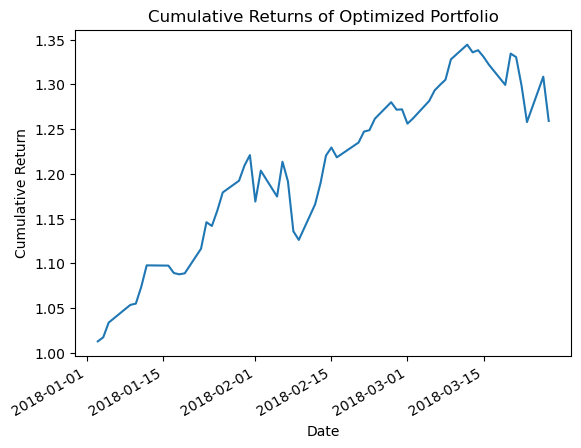

In [16]:
#plotting cumulative returns
import matplotlib.pyplot as plt

cumulative_returns.plot(title = 'Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

## 6. Visualize the Efficient Frontier

The efficient frontier represents a set of optimal portfolios that give the highest return for a given level of risk, and the lowest risk for the given level of expected return.

These portfolios are 'efficient' because they're well-balanced (Mean-Variance Optimization i.e., Return-risk tradeoff).

In [17]:
import numpy as np

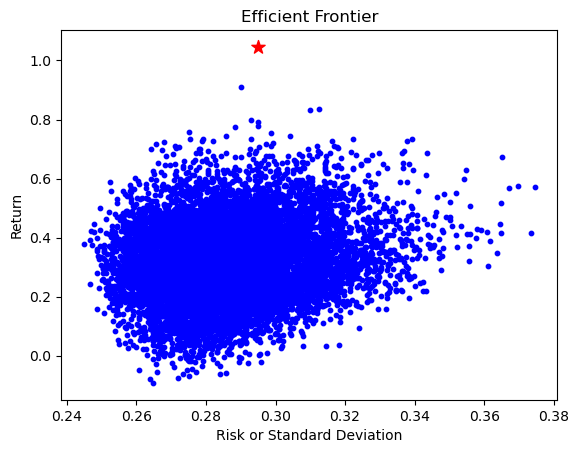

In [19]:
#to generate random portfolios
n_portfolios = 10000
risk_data = []
return_data = []

for _ in range(n_portfolios):
    random_weights = np.random.random(n_assets)
    random_weights /= np.sum(random_weights)
    risk = np.sqrt(random_weights.T @ cov_matrix @ random_weights)
    return_ = random_weights @ expected_returns
    risk_data.append(risk)
    return_data.append(return_)
    
#to plot the Efficient Frontier
plt.scatter(risk_data, return_data, c = 'blue', marker = 'o', s = 10)
plt.scatter(np.sqrt(portfolio_risk.value), portfolio_return.value, c = 'red', marker = '*', s = 100)
plt.xlabel('Risk or Standard Deviation')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

## 7. Sharpe Ratio

To estimate the optimized portfolio, we calculate the Sharpe Ratio.

Higher the Sharpe Ratio, better is the return to risk ratio.

It is an indication that it is more safer to invest in that particular stock.

In [21]:
#define the risk-free rate
#we assume that it is at 2%
risk_free_rate = 0.02

#calculating the Sharpe Ratio
sharpe_ratio = (portfolio_return.value - risk_free_rate) / np.sqrt(portfolio_risk.value)
print(f'Sharpe Ratio: {round(sharpe_ratio, 2)}')

Sharpe Ratio: 3.48


A Sharpe Ratio of greater than 3 indicates that the risk-adjusted return is excellent.